In [10]:
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.oauth2 as oauth2
import pandas as pd
import numpy as np
import configparser

In [11]:
#Authenticate with config file and spotipy client_id, client_secret, username, values

config = configparser.ConfigParser()
config.read('config_ernflerberg.cfg')
client_id = config.get('SPOTIFY', 'CLIENT_ID')
client_secret = config.get('SPOTIFY', 'CLIENT_SECRET')
username = config.get('SPOTIFY', 'USERNAME')


auth = oauth2.SpotifyClientCredentials(
    client_id=client_id,
    client_secret=client_secret
)

token = auth.get_access_token()
sp = spotipy.Spotify(auth=token)

In [12]:
def getTrivialInfo(playlistList):
    dfTrivialList=[]
    for playlist in playlistList:
        index=0
        dfTrivial = pd.DataFrame(columns=('SongName', 'SongId', 'SongArtist'), index=np.arange(0, len(playlist['tracks']['items'])))
        for item in playlist['tracks']['items']:
            track = item['track']
            dfTrivial.loc[index]=[track['name'], track['id'], track['artists'][0]['name']]
            index+=1
        dfTrivialList.append(dfTrivial)
    return dfTrivialList

In [13]:
def getSongList(dfTrivialList):
    songIdsList=[]
    for dfTrivial in dfTrivialList:
        songIds=list(dfTrivial['SongId'])
        songIdsList.append(songIds)
    return songIdsList

In [14]:
def getFeaturesList(dfTrivialList, songIdsList, columns=('SongName', 'Danceability', 'Energy', 'Loudness', 'Speechiness', 'Acousticness', 'Valence', 'Instrumentalness','Tempo')):
    dfFeaturesList=[]
    for dfTrivial, songIds in zip(dfTrivialList, songIdsList):
        index=0
        audioFeatures = sp.audio_features(tracks=songIds)
        categories=columns[1:]
        dfFeatures = pd.DataFrame(columns=columns, index=np.arange(0, len(songIds)))
        for i, song in enumerate(audioFeatures):
            dfFeatures.loc[index]=[list(dfTrivial['SongName'])[i], song['danceability'], song['energy'], song['loudness'], song['speechiness'], song['acousticness'], song['valence'], song['instrumentalness'], song['tempo']]
            index+=1
        dfFeaturesList.append(dfFeatures)
    return dfFeaturesList

In [15]:
def getFeaturesToUse(dfFeaturesList, categories=['Danceability','Energy', 'Speechiness', 'Acousticness', 'Valence']):
    featuresToUseList=[]
    for dfFeatures in dfFeaturesList:
        features = dfFeatures[categories]
        featuresToUseList.append(features)
    return featuresToUseList

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from math import pi
import operator

In [17]:
def featurePreprocessing(song, categories=['Danceability','Energy', 'Speechiness', 'Acousticness', 'Valence']):
    return song[categories]

In [18]:
playlistDictionary={
                   "Liked": "37i9dQZF1DWY4xHQp97fN6",
                   "Dislike": "37i9dQZF1DWWEJlAGA9gs0"
                   }

In [19]:
LikedId=playlistDictionary["Liked"]
DislikeId=playlistDictionary["Dislike"]
spotifyUsername='Spotify'

likedplay=sp.user_playlist(spotifyUsername, playlist_id=LikedId)
dislikeplay=sp.user_playlist(spotifyUsername, playlist_id=DislikeId)

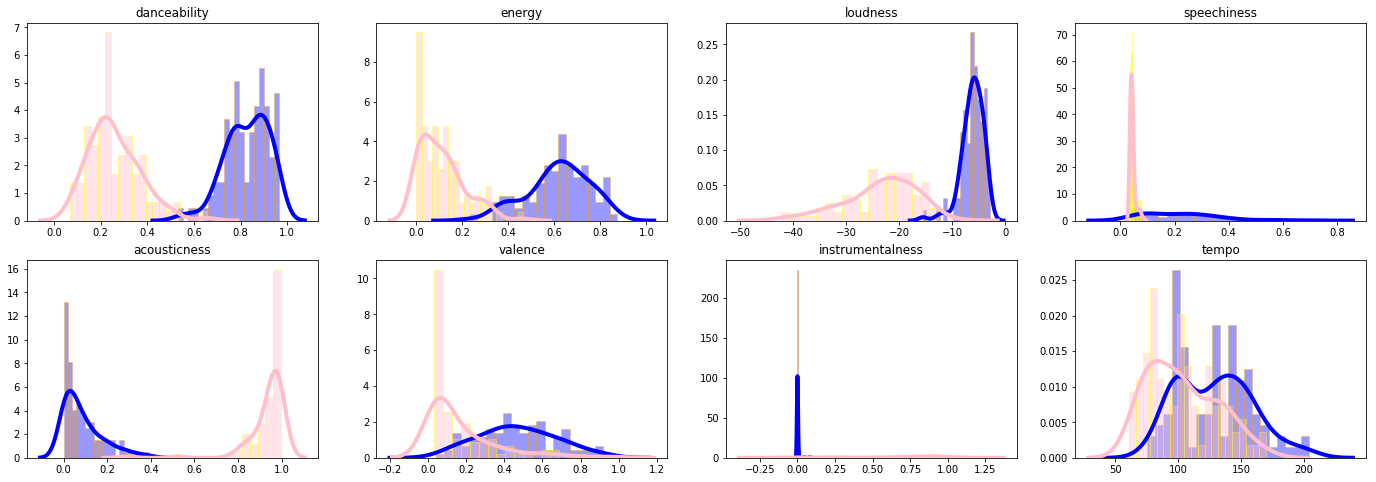

In [20]:
column=('songName', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'valence', 'instrumentalness','tempo')
playlistList=[likedplay, dislikeplay]
n_bins=20
fig, axs = plt.subplots(figsize=(24, 8), nrows=2, ncols=4)
axs=axs.flatten()
dfTrivialList=getTrivialInfo(playlistList)
songIdsList=getSongList(dfTrivialList)
songIds1=songIdsList[0]
songIds2=songIdsList[1]

audioFeatures1 = sp.audio_features(tracks=songIds1)
audioFeatures2 = sp.audio_features(tracks=songIds2)

for song1, song2 in zip(audioFeatures1, audioFeatures2):
    if song1 is None:
        audioFeatures1.remove(song1)
    if song2 is None:
        audioFeatures2.remove(song2)
            
index=0
for feature in column[1:]:
    ax=axs[index]
    ax.set_title(feature)
    featureListToPlot1 = []
    featureListToPlot2 = []

    for song1, song2 in zip(audioFeatures1, audioFeatures2):
        featureListToPlot1.append(song1[feature])
        featureListToPlot2.append(song2[feature])


    sns.distplot(featureListToPlot1, hist=True, bins=n_bins, color = 'blue', hist_kws={'edgecolor':'orange'}, kde_kws={'linewidth': 4}, ax=ax)
    sns.distplot(featureListToPlot2, hist=True, bins=n_bins, color = 'pink', hist_kws={'edgecolor':'yellow'}, kde_kws={'linewidth': 4}, ax=ax)
    index+=1

In [21]:
categories = column[1:]
tempoFeaturesTogether=[]
loudnessFeaturesTogether=[]

for song1, song2 in zip(audioFeatures1, audioFeatures2):
    tempoFeaturesTogether.append(song1['tempo'])
    tempoFeaturesTogether.append(song2['tempo'])

    loudnessFeaturesTogether.append(song1['loudness'])
    loudnessFeaturesTogether.append(song2['loudness'])
    
minimumTempo=min(tempoFeaturesTogether)
maximumTempo=max(tempoFeaturesTogether)
minimumLoudness=min(loudnessFeaturesTogether)
print(minimumLoudness)
maximumLoudness=max(loudnessFeaturesTogether)
print(maximumLoudness)

for song1, song2 in zip(audioFeatures1, audioFeatures2):
    song1['tempo']=(song1['tempo']-minimumTempo)/(maximumTempo-minimumTempo)
    song2['tempo']=(song2['tempo']-minimumTempo)/(maximumTempo-minimumTempo)

    song1['loudness']=(song1['loudness']-minimumLoudness)/(maximumLoudness-minimumLoudness)
    song2['loudness']=(song2['loudness']-minimumLoudness)/(maximumLoudness-minimumLoudness)


dfFeaturesList=[]
audioFeaturesList=[audioFeatures1, audioFeatures2]
for audioFeatures in audioFeaturesList:
    dfFeatures = pd.DataFrame(columns=categories, index=np.arange(0, len(audioFeatures)))
    for i, song in enumerate(audioFeatures[:99]):
        print(song['loudness'])
        dfFeatures.loc[i]=[song['danceability'], song['energy'], song['loudness'], song['speechiness'], song['acousticness'], song['valence'], song['instrumentalness'], song['tempo']]
    
    dfFeaturesList.append(dfFeatures)

for i in range(len(dfFeaturesList)):
    dfFeaturesList[i]=dfFeaturesList[i].mean()

dfFeaturesList=pd.concat(dfFeaturesList, axis=1)

-42.32
-2.806
0.9251404565470465
0.9306827959710481
0.9384268866730779
0.900541580199423
0.7745862226046464
0.930455028597459
0.9069696816318267
0.942476084425773
0.8838639469555093
0.8841423293010072
0.9521688515462874
0.744799311636382
0.8660474768436504
0.9532570734423242
0.8911778103963152
0.9122842536822392
0.9448296806195272
0.9685427949587487
0.8715138938097888
0.9047173153818899
0.9800830085539303
0.9202561117578579
0.9385281166168953
0.8984916738371209
0.9641139849167384
0.9161816065192082
0.9816520726830996
0.9724401477957179
0.8939616338512931
0.909930657488485
0.8830287999190161
0.9857771928936578
0.9658855089335424
0.9117274889912437
0.9014020347218707
0.8439793490914613
0.935288758414739
0.9636584501695602
0.6776079364275952
0.9269625955357594
0.9117527964771979
0.9063116869970136
0.9408310978387406
0.8651870223212025
0.914182315128815
0.8665283190767828
0.9445512982740294
0.9696310168547856
0.9361998279090955
1.0
0.8826744951156551
0.9081085184997723
0.86470618008807
0.9

[0.8274545454545453, 0.6172929292929289, 0.9142367645682922, 0.21878585858585853, 0.08753044444444447, 0.4691292929292931, 0.0015058442424242427, 0.4731336880101839]
[0.25875353535353535, 0.11084535353535353, 0.4764440988311009, 0.0446868686868687, 0.9362020202020204, 0.16734747474747477, 0.6623496123232326, 0.29526423708076494]


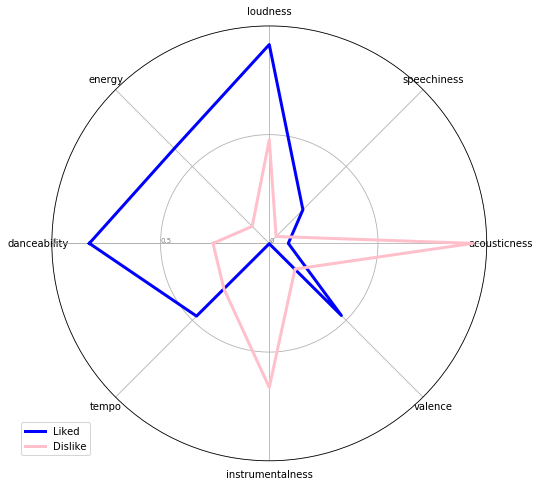

In [22]:
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

fig = plt.figure(figsize=(8,8))
ax = plt.subplot(111, polar=True)
ax.set_theta_offset(pi)
ax.set_theta_direction(-1)
 
plt.xticks(angles, categories)

ax.set_rlabel_position(0)
plt.yticks([0, 0.5, 1], ["0", "0.5", "1"], color="grey", size=7)
plt.ylim(0, 1)
 

# Ind1
colors=['b', 'pink']
for i, key in enumerate(playlistDictionary.keys()):
    if i <4:
        values=list(dfFeaturesList[i])
        print(values)
        values += values[:1]
        ax.plot(angles, values, color=colors[i], linewidth=3, linestyle='solid', label=key)
 
# Add legend
plt.legend(bbox_to_anchor=(0.1, 0.1))

In [23]:
def euclideanDistance(data1, data2, weight, length):
    distance = 0
    for x in range(length):
        distance += np.square(weight[x]*(data1[x] - data2[x]))
    return np.sqrt(distance)

def distances(trainingSet, testSong, weight):
    distanceDict = {}
    length = testSong.shape[0]
    for genre, features in trainingSet.items():
        dist = [[euclideanDistance(features.iloc[x], testSong, weight, length), x] for x in range(len(features))]
        distanceDict[genre] = dist
    return distanceDict

In [26]:
def knn(sortedDistances, k):
    counter={}
    for key in sortedDistances.keys():
        counter[key] =0 
    minKey=''
    minId=0
    neighborKeyAndId=[]
    for i in range(k):
        minValue=5
        for key, value in sortedDistances.items():
            if value[0][0]<minValue:
                minId=value[0][1]
                minKey=key
                minValue = value[0][0]
        del(sortedDistances[minKey][0])
        counter[minKey]=counter[minKey]+1
        neighborKeyAndId.append([minKey, minId])
    return counter, neighborKeyAndId

In [27]:
playlistList=[likedplay, dislikeplay]

In [28]:
dfTrivialList=getTrivialInfo(playlistList);
songIdsList=getSongList(dfTrivialList);
dfFeaturesList=getFeaturesList(dfTrivialList, songIdsList, columns=('SongName', 'Danceability', 'Energy', 'Loudness', 'Speechiness', 'Acousticness', 'Valence', 'Instrumentalness','Tempo'))
print(dfFeaturesList[1].iloc[48])
featuresToUseList=getFeaturesToUse(dfFeaturesList, categories=['Danceability','Energy', 'Speechiness', 'Acousticness', 'Valence','Instrumentalness'])
print(featuresToUseList[1])

SongName            Les Baricades Mistérieuses (6e ordre)
Danceability                                        0.191
Energy                                             0.0946
Loudness                                           -25.59
Speechiness                                        0.0365
Acousticness                                         0.99
Valence                                             0.348
Instrumentalness                                    0.933
Tempo                                             110.502
Name: 48, dtype: object
   Danceability   Energy Speechiness Acousticness Valence Instrumentalness
0          0.23   0.0487      0.0412        0.986   0.101            0.945
1         0.244   0.0325      0.0457        0.992  0.0406            0.879
2         0.244     0.12       0.073        0.972  0.0323            0.768
3         0.227   0.0843      0.0384        0.974  0.0737            0.789
4         0.235    0.166      0.0347        0.992  0.0356             0.87
5   

In [29]:
f1= featuresToUseList[0][:35]
f2= featuresToUseList[1][:35]

trainingSet = {'1': f1, '2': f2}
for i in range(len(featuresToUseList)):
    print(i)
    accurate=0
    total=0
    for j in range(35,99):
        distanceList=distances(trainingSet, featuresToUseList[i].iloc[j], [1,1,1,1,1,1])
        print(dfFeaturesList[i].iloc[j])
        sortedDict={}
        for key in distanceList.keys():
            sortedDict[key]=sorted(distanceList[key], key=operator.itemgetter(0))
        counter, neighborKeyAndId = knn(sortedDict, 25)
        prediction=max(counter.items(), key=operator.itemgetter(1))[0]
        if(i+1 == int(prediction)):
            accurate+=1
        total+=1
        print(counter)
    print(float(accurate/total))

0
SongName            REEL IT IN (feat. Gucci Mane) - Remix
Danceability                                        0.779
Energy                                              0.355
Loudness                                           -8.971
Speechiness                                        0.0789
Acousticness                                       0.0624
Valence                                             0.362
Instrumentalness                                        0
Tempo                                             128.805
Name: 35, dtype: object
{'1': 25, '2': 0}
SongName            Girls Have Fun (feat. G-Eazy & Rich The Kid)
Danceability                                               0.888
Energy                                                      0.74
Loudness                                                  -5.363
Speechiness                                                0.238
Acousticness                                             0.00586
Valence                                     